# Reading-in and Downloading ALS Vendor Products

* coincident.io.xarray
    * load_usgs_dem
    * load_neon_dem
    * load_ncalm_dem

* coincident.io.download
    * download_usgs_dem
    * download_usgs_lpc
    * download_neon_dem (includes an option for LPCs as well)
    * download_noaa_lpc
    * download_ncalm_dem (includes an option for LPCs as well)

```{warning}
PDAL dependency mess
```

In [1]:
import coincident
import geopandas as gpd
from shapely.geometry import box
%load_ext autoreload
%autoreload 2

/home/jehayes/coincident/src/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


Example with 3DEP & NEON overlap

In [2]:
workunit = "CO_CentralEasternPlains_1_2020"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_lidar = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)

gf_lidar

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_CentralEasternPlains_1_2020,192973,CO_CentralEasternPlains_2020_D20,192976,2020-05-09,2020-06-10,QL 2,USGS Lidar Base Specification 2.1,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-103.7138 39.8835, -103.7138 3...",3DEP,2020-05-25,146,32


In [3]:
# We will examine the 'sourcedem' 1m
# NOTE: it's important to note the *vertical* CRS of the data
gf_lidar.iloc[0]

workunit                                 CO_CentralEasternPlains_1_2020
workunit_id                                                      192973
project                                CO_CentralEasternPlains_2020_D20
project_id                                                       192976
start_datetime                                      2020-05-09 00:00:00
end_datetime                                        2020-06-10 00:00:00
ql                                                                 QL 2
spec                                  USGS Lidar Base Specification 2.1
p_method                                              linear-mode lidar
dem_gsd_meters                                                      1.0
horiz_crs                                                          6342
vert_crs                                                           5703
geoid                                                           GEOID18
lpc_pub_date                                        2020-12-11 0

In [4]:
gf_neon = coincident.search.search(dataset="neon", intersects=gf_lidar, datetime=["2020"])

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [5]:
m = gf_lidar.explore(color='black')
gf_neon.explore(m=m, column="id", popups=True)

In [6]:
gf_wc = coincident.search.search(
    dataset="worldcover",
    intersects=gf_neon,
    datetime=["2020"],
) 

In [7]:
# Same with LandCover
dswc = coincident.io.xarray.to_dataset(
    gf_wc,
    bands=["map"],
    aoi=gf_neon,
    mask=True,
    resolution=0.00027, #~30m
)
dswc = dswc.rename(map="landcover")
dswc = dswc.compute()

In [33]:
bbox_geometry = box(-102.505, 39.675, -102.49, 39.685)
aoi = gpd.GeoDataFrame(
    geometry=[bbox_geometry],
    crs="EPSG:4326"
)

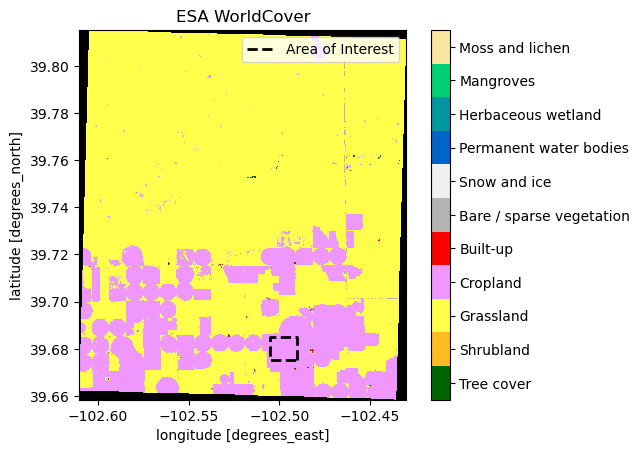

In [9]:
ax = coincident.plot.plot_esa_worldcover(dswc)
aoi.plot(ax=ax, 
         facecolor='none',
         edgecolor='black',
         linestyle="--",
         linewidth=2)
from matplotlib.lines import Line2D
custom_line = Line2D([0], [0], color='black', linestyle='--', lw=2)
ax.legend([custom_line], ['Area of Interest'], loc='upper right', fontsize=10)
ax.set_title("ESA WorldCover");

Actually read-in and download the DEMs and LPCs now

In [10]:
coincident.io.xarray.load_neon_dem?

Signature:
coincident.io.xarray.load_neon_dem(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    product: 'str',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge NEON LiDAR tiles (DSM, DTM, or CHM) based on an AOI by querying the NEON API.

Steps:
    1. Convert the datetime string to a month string in the format YYYY-MM.
    2. Determine appropriate UTM CRS for the AOI.
    3. Query the NEON API using a preset product code.
    4. Filter the returned files based on product type and spatial intersection.
    5. Load and optionally coarsen each GeoTIFF tile.
    6. Merge the tiles and optionally clip the mosaic to the AOI.

Parameters:
    aoi (gpd.GeoDataFrame): Area of interest geometry to query against
    datetime_str (str): Date string in YYYY-MM-DD format
    site_id (str): NEON site identifier
    product (str): Product type to load ('dsm', 'dtm', or 'chm')
    res (int): Resolution factor to coarsen DEM by (de

In [11]:
datetime_str = gf_neon.end_datetime.item().strftime('%Y-%m-%d')
site_id = gf_neon.id.item()
datetime_str, site_id

('2020-06-10', 'ARIK')

In [12]:
%%time
ds_neon_dem = coincident.io.xarray.load_neon_dem(aoi,
                                          datetime_str=datetime_str,
                                          site_id=site_id,
                                          product="dsm")

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: 

CPU times: user 403 ms, sys: 91 ms, total: 494 ms
Wall time: 4.8 s


In [20]:
ds_neon_dem

<xarray.DataArray 'elevation' (y: 1146, x: 1318)> Size: 6MB
dask.array<getitem, shape=(1146, 1318), dtype=float32, chunksize=(808, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 7.14e+05 7.14e+05 ... 7.153e+05 7.153e+05
  * y            (y) float64 9kB 4.395e+06 4.395e+06 ... 4.396e+06 4.396e+06
    spatial_ref  int64 8B 0

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


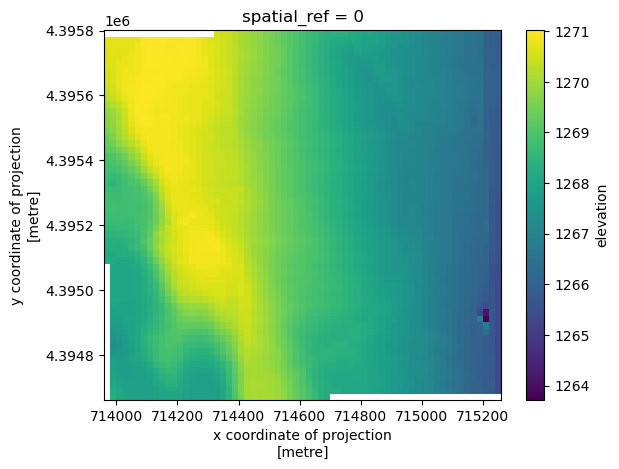

In [19]:
ds_neon_dem.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

In [13]:
usgs_project = gf_lidar['project'].item()
usgs_project

'CO_CentralEasternPlains_2020_D20'

NOTE: the below doesn't work due to the TNM API issues

In [14]:
%%time
ds_usgs_dem = coincident.io.xarray.load_usgs_dem(aoi, usgs_project)

ValueError: TNM API returned no products for the given AOI and dataset.

Download time (note that I'm working on removing the left_join column)

In [21]:
gf_neon

,id,title,start_datetime_left,end_datetime_left,product_url,geometry,workunit_left,workunit_id_left,project_left,project_id_left,...,onemeter_reason_right,seamless_category_right,seamless_reason_right,lpc_link_right,sourcedem_link_right,metadata_link_right,collection_right,datetime_right,dayofyear_right,duration_right
0,ARIK,Arikaree River NEON,2020-06,2020-06,https://data.neonscience.org/api/v0/data/DP3.3...,"POLYGON ((-102.60902 39.69825, -102.60871 39.7...",CO_CentralEasternPlains_1_2020,192973,CO_CentralEasternPlains_2020_D20,192976,...,Meets 3DEP 1-m DEM requirements,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,3DEP,2020-05-25,146,32


In [24]:
local_output_dir = "/home/jehayes/coincident/local_data" # in our .gitignore
# NOTE: NEON needs it's end_datetime, not start_datetime (separated by 1 month) to work, will fix the hardcoded arg
coincident.io.download.download_neon_dem(aoi=aoi,
                                        datetime_str="2020-06-01",
                                        site_id=gf_neon.id.item(),
                                        product="dsm",
                                        output_dir=local_output_dir)

In [34]:
coincident.io.download.download_neon_dem(aoi=aoi,
                                        datetime_str="2020-06-01",
                                        site_id=gf_neon.id.item(),
                                        product="lpc",
                                        output_dir=local_output_dir)

usgs example after TNM API is back up

Now we do the other catalogs, woohoo

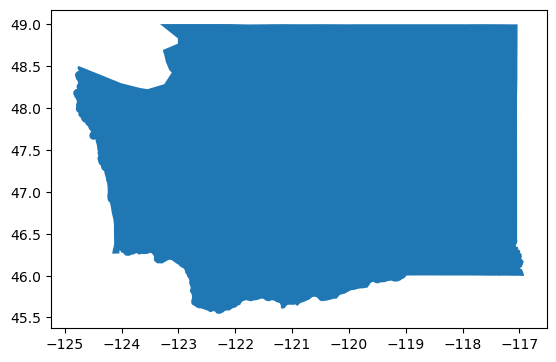

In [25]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson"
)
aoi.plot();

In [26]:
gf_ncalm = coincident.search.search(dataset="ncalm", intersects=aoi, datetime=["2018-09-19"])

In [28]:
gf_ncalm

,id,name,title,start_datetime,end_datetime,geometry
0,OTLAS.072019.6339.1,WA18_Wall,"High-Resolution Mapping of Goat Rock Volcano, WA",2018-09-19,2018-09-20,"POLYGON ((-121.46701 46.48376, -121.45914 46.4..."


Now, let's subset to a small AOI for convenience sake

In [29]:
from shapely.geometry import box
buffer_size = 0.01
centroid = gf_ncalm.centroid
mini_aoi = gpd.GeoDataFrame(
    geometry=[box(centroid.x-buffer_size, centroid.y-buffer_size, 
                 centroid.x+buffer_size, centroid.y+buffer_size)],
    crs="EPSG:4326"
)

/tmp/ipykernel_253348/1050128113.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gf_ncalm.centroid
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [31]:
m = gf_ncalm.explore()
mini_aoi.explore(m=m, color='red')

NOTE: The NCALM and user submitted opentopo DEMs are very strange in terms of metadata and tiling. For this site specifically, there are no tiles, just the entire site. this makes it so we have to load the entire dataset into memory

Also, they have strange naming conventions. Below are the s3 urls for this site. I'm not sure what GEG vs GEF is. I loaded them in and plotted them. They're overlapping and have nearly-identical elevation values (mms of difference). Because of this, the function by default returns the first file with a .tif extension it sees in the respective bucket

dem_urls = [
    "https://opentopography.s3.sdsc.edu/raster/WA18_Wall/WA18_Wall_be/WALL_GEG_1M.tif",
    "https://opentopography.s3.sdsc.edu/raster/WA18_Wall/WA18_Wall_hh/WALL_GEF_1M.tif"
]

In [32]:
%%time
ds_ncalm_dem = coincident.io.xarray.load_ncalm_dem(aoi=mini_aoi, dataset_id=gf_ncalm['name'].item())

CPU times: user 7.66 s, sys: 3.89 s, total: 11.5 s
Wall time: 21.7 s


In [35]:
ds_ncalm_dem

<xarray.Dataset> Size: 14MB
Dimensions:      (x: 1579, y: 2254)
Coordinates:
  * x            (x) float64 13kB 6.226e+05 6.226e+05 ... 6.242e+05 6.242e+05
  * y            (y) float64 18kB 5.152e+06 5.152e+06 ... 5.15e+06 5.15e+06
    spatial_ref  int64 8B 0
Data variables:
    elevation    (y, x) float32 14MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

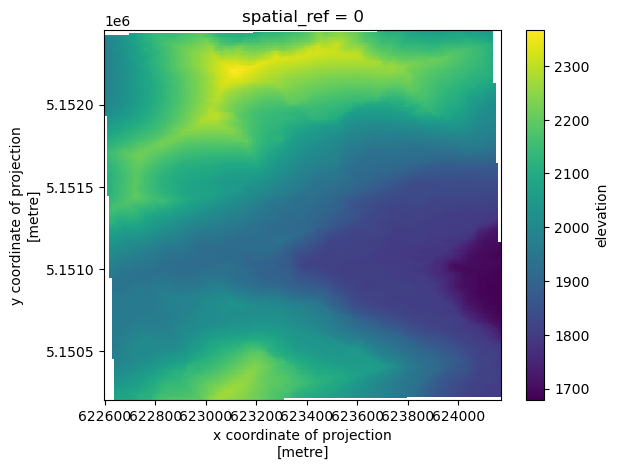

In [36]:
ds_ncalm_dem.elevation.coarsen(x=10, y=10, boundary='trim').mean().plot.imshow();

My laptop is chugging right now... this one doesn't usually take 40 seconds

Also, seems like I saved both the GEF and FEF DEMs, need to fix that

In [39]:
%%time
coincident.io.download.download_ncalm(aoi=mini_aoi,
                                      dataset_id=gf_ncalm['name'].item(),
                                      data_type="dem",
                                      output_dir=local_output_dir)

CPU times: user 17 s, sys: 5.39 s, total: 22.4 s
Wall time: 35.9 s


I'm thinking about workarounds to avoid using pdal for LPC data processing, I was able to do so with the NEON and USGS funcs using the coincident.io.download._download_files helper func...

In [40]:
%%time
coincident.io.download.download_ncalm(aoi=mini_aoi,
                                      dataset_id=gf_ncalm['name'].item(),
                                      data_type="lpc",
                                      output_dir=local_output_dir)

ImportError: PDAL Python bindings are required for this functionality. Please try 'mamba install pdal' in your cli

noaa time

In [43]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/FL/shape.geojson"
)
gf_noaa = coincident.search.search(dataset="noaa", intersects=aoi, datetime=["2022-10-27"])

In [44]:
gf_noaa.explore()

the name and id being identical is expetced

In [45]:
gf_noaa

,id,name,title,start_datetime,end_datetime,geometry
0,10149,10149,"2022 NOAA NGS Topobathy Lidar: Big Bend WMA, FL",2022-10-27,2022-11-29,"POLYGON ((-83.4654 29.36713, -83.35291 29.4196..."


In [46]:
%%time
coincident.io.download.download_noaa_lpc(aoi=aoi,
                                         dataset_id=gf_noaa.id.item(),
                                         output_file=local_output_dir)

ImportError: PDAL Python bindings are required for this functionality. Please try 'mamba install pdal' in your cli